In [1]:
%load_ext autoreload

import os
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# OPV NN2

### This notebook to uses OPV processing conditions and summary morphology descriptions to predict device performance.


# Dataset definition

In [2]:
#Take in data as a dataframe for easy preprocessing
train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

total_df = pd.concat([train_df, test_df])

print (f'total_df shape: {total_df.shape}')
print (f'test_df shape: {test_df.shape}')
test_df.head()

total_df shape: (36, 60)
test_df shape: (10, 60)


,Unnamed: 0,Anneal_temp,Anneal_time,Device,FF,Jsc,PCE,Substrate,VocL,p1_Ecc_avg,...,p3_Orient_stdev,p3_Perim_avg,p3_Perim_stdev,p3_area_avg,p3_area_stdev,p3_extent_avg,p3_extent_stdev,p3_filled_area_avg,p3_filled_area_stdev,p3_fraction
0,25,175,15,3,0.909801,0.734816,0.757737,4,0.869393,0.280982,...,0.680864,0.771321,0.391287,0.579239,0.345826,0.182720,0.483376,0.574514,0.327855,0.680201
1,18,125,5,6,0.938871,0.923073,0.911244,1,0.806521,0.413870,...,0.651856,0.351606,0.061201,0.259887,0.078107,0.782412,0.298828,0.257329,0.072969,0.102921
2,5,100,30,7,0.919421,0.993903,0.960996,7,0.806653,0.321180,...,0.312428,0.755107,0.750574,0.633830,0.855980,0.234678,0.580329,0.633682,0.822952,1.000000
3,23,150,5,7,1.000000,0.935089,0.998002,1,0.818655,0.077712,...,0.685357,0.238873,0.000000,0.158390,0.018924,0.791579,0.232388,0.156827,0.016847,0.000000
4,14,125,30,3,0.970085,0.922020,0.967129,8,0.829387,0.468122,...,0.601669,0.443481,0.093211,0.365298,0.127393,0.959475,0.400562,0.361884,0.119575,0.291165


In [11]:
# Hyper parameters
num_epochs = 100
learning_rate = 1e-5

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
x_train = total_df.drop(['PCE', 'VocL', 'Jsc', 'FF', 'Unnamed: 0', 'Substrate', 'Device'], axis = 1)#input features used to make prediction
y_train = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_test = test_df.drop(['PCE', 'VocL', 'Jsc', 'FF', 'Unnamed: 0', 'Substrate', 'Device'], axis = 1)
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

# Fit model with variety of learning rates and epochs to find best hyperparameters

In [31]:
%autoreload

def fit(model, lr, epochs):
    
    #define the optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    
    #empty list to hold loss per epoch
    train_epoch_losses = []
    pce_train_epoch_losses = []
    voc_train_epoch_losses = []
    jsc_train_epoch_losses = []
    ff_train_epoch_losses = []

    test_epoch_losses = []
    pce_test_epoch_losses = []
    voc_test_epoch_losses = []
    jsc_test_epoch_losses = []
    ff_test_epoch_losses = []

    pce_test_epoch_accuracies = []
    voc_test_epoch_accuracies = []
    jsc_test_epoch_accuracies = []
    ff_test_epoch_accuracies = []
    test_epoch_accuracies = []

    pce_test_epoch_r2 = []
    voc_test_epoch_r2 = []
    jsc_test_epoch_r2 = []
    ff_test_epoch_r2 = []
    test_epoch_r2s = []

    save_epochs = np.arange(0, num_epochs, 5)

    for epoch in range(epochs):
        print('On epoch ', epoch)

    #     save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    #     model_name = "OPV_NN2"
    #     model_path = save_dir+model_name+'*.pt'
    #     if epoch < 10:
    #         save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    #     else:
    #         save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'

    #     if glob.glob(model_path) != []:
    #         model_states = glob.glob(model_path)
    #         model_states = sorted(model_states)
    #         previous_model = model_states[-1]    

    #         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)

        model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,                                                                                                     training_data_set = training_data_set,
                                                                                                             optimizer = optimizer)
        train_epoch_losses.append(train_loss)
        pce_train_epoch_losses.append(pce_train_loss)
        voc_train_epoch_losses.append(voc_train_loss)
        jsc_train_epoch_losses.append(jsc_train_loss)
        ff_train_epoch_losses.append(ff_train_loss)

        test_losses, test_accs, test_r2s = test.eval_OPV_df_model(model = model,
                                                                  testing_data_set = testing_data_set)
        pce_test_epoch_losses.append(test_losses[0])
        voc_test_epoch_losses.append(test_losses[1])
        jsc_test_epoch_losses.append(test_losses[2])
        ff_test_epoch_losses.append(test_losses[3])

        tot_tst_loss = sum(test_losses)
        test_epoch_losses.append(tot_tst_loss)

        pce_test_epoch_accuracies.append(test_accs[0])
        voc_test_epoch_accuracies.append(test_accs[1])
        jsc_test_epoch_accuracies.append(test_accs[2])
        ff_test_epoch_accuracies.append(test_accs[3])

        tot_tst_acc = sum(test_accs)
        test_epoch_accuracies.append(tot_tst_acc)

        pce_test_epoch_r2.append(test_r2s[0])
        voc_test_epoch_r2.append(test_r2s[1])
        jsc_test_epoch_r2.append(test_r2s[2])
        ff_test_epoch_r2.append(test_r2s[3])

        tot_tst_r2 = sum(test_r2s)
        test_epoch_r2s.append(tot_tst_r2)

        #nuts.save_trained_model(save_path, epoch, model, optimizer)
        
        print('Finished epoch ', epoch)
        
    best_loss_indx = test_epoch_losses.index(min(test_epoch_losses))
    best_acc_indx = test_epoch_accuracies.index(min(test_epoch_accuracies))
    best_r2_indx = test_epoch_r2s.index(max(test_epoch_r2s))
    
    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        'best_r2_epoch': best_r2_indx,
        'pce_loss': pce_test_epoch_losses,
        'voc_loss': voc_test_epoch_losses,
        'jsc_loss': jsc_test_epoch_losses,
        'ff_loss': ff_test_epoch_losses,
        'test_losses': test_epoch_losses,        
        'pce_acc': pce_test_epoch_accuracies,
        'voc_acc': voc_test_epoch_accuracies,
        'jsc_acc': jsc_test_epoch_accuracies,
        'ff_acc': ff_test_epoch_accuracies,
        'test_accs': test_epoch_accuracies,
        'pce_r2': pce_test_epoch_r2,
        'voc_r2': voc_test_epoch_r2,
        'jsc_r2': jsc_test_epoch_r2,
        'ff_r2': ff_test_epoch_r2,
        'test_r2s': test_epoch_r2s,
        'train_pce_loss': pce_train_epoch_losses,
        'train_voc_loss': voc_train_epoch_losses,
        'train_jsc_loss': jsc_train_epoch_losses,
        'train_ff_loss': ff_train_epoch_losses
    }

    return fit_results

In [13]:
%autoreload

in_dims = int(x_train.shape[1]) #number of x channels

In [14]:
%autoreload

cv_fits = {}

kf = KFold(n_splits = 5)

for fold, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
    print(f'Fold # {fold}')
    print('-----------------------------')
    
    train_loader, test_loader = nuts.get_fold_dataloaders_df(x_train, y_train, train_index, test_index)
        
    model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
    model.apply(nuts.init_weights)
    
    cv_fits[fold] = nuts.CV_OPV_fit(model, train_loader, test_loader, lr = learning_rate, epochs = num_epochs)


Fold # 0
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 97.36470031738281
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 90.84548

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 93.85629272460938
                              Voc = 7.863938808441162
                              Jsc = 61.411903381347656
                              FF = 67.53927612304688
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 89.89044189453125
                              Voc = 6.793779373168945
                              Jsc = 53.80754470825195
                              FF = 64.169189453125
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 85.52530670166016
                              Voc = 9.968793869018555
                              Jsc = 47.48798370361328
                              FF = 62.744140625
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 82.50939178466797
                              Voc = 14.872889518737793
                              Jsc = 41.30122756958008
                              FF = 58.40800476074219
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 7

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 70.07030487060547
                              Voc = 34.35304641723633
                              Jsc = 21.2544002532959
                              FF = 49.44293975830078
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 69.3273696899414
                              Voc = 30.258201599121094
                              Jsc = 17.012670516967773
                              FF = 49.6370735168457
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 68.41476440429688
                              Voc = 28.28447723388672
                              Jsc = 22.36566162109375
                              FF = 48.30672836303711
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 68.20616912841797
                              Voc = 27.437654495239258
                              Jsc = 21.50678062438965
                              FF = 47.56440353393555
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 67.25617980957031
                              Voc = 7.71491003036499
                              Jsc = 20.22861099243164
                              FF = 47.43593215942383
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 68.59846496582031
                              Voc = 8.343501091003418
                              Jsc = 18.929698944091797
                              FF = 45.166603088378906
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 72.53303527832031
                              Voc = 8.103931427001953
                              Jsc = 18.296707153320312
                              FF = 44.17459487915039
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 72.85962677001953
                              Voc = 10.28089714050293
                              Jsc = 21.120189666748047
                              FF = 43.76606750488281
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 73.77206420898438
                              Voc = 13.68425178527832
                              Jsc = 9.434358596801758
                              FF = 39.9578857421875
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 70.11045837402344
                              Voc = 13.511932373046875
                              Jsc = 9.271727561950684
                              FF = 41.84278106689453
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 69.47232818603516
                              Voc = 13.767833709716797
                              Jsc = 9.769020080566406
                              FF = 41.61516571044922
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 67.25936126708984
                              Voc = 14.086845397949219
                              Jsc = 10.239490509033203
                              FF = 39.923519134521484
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 62.505401611328125
                              Voc = 13.882345199584961
                              Jsc = 11.296954154968262
                              FF = 39.17436599731445
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 62.998050689697266
                              Voc = 13.996418952941895
                              Jsc = 11.07295036315918
                              FF = 39.682735443115234
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 63.787384033203125
                              Voc = 14.067977905273438
                              Jsc = 10.484478950500488
                              FF = 39.6436767578125
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 64.07848358154297
                              Voc = 13.788649559020996
                              Jsc = 10.011592864990234
                              FF = 41.03486251831055
Finished epoch  69
On epoch  70
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 51.83142852783203
                              Voc = 15.820052146911621
                              Jsc = 12.076117515563965
                              FF = 35.63213348388672
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 55.628211975097656
                              Voc = 15.284152030944824
                              Jsc = 13.173264503479004
                              FF = 35.059120178222656
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 57.185577392578125
                              Voc = 14.98734188079834
                              Jsc = 13.416740417480469
                              FF = 34.552024841308594
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 57.115234375
                              Voc = 15.457189559936523
                              Jsc = 13.177910804748535
                              FF = 34.43602752685547
Finished epoch  83
On epoch  84
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 73.6780776977539
                              Voc = 10.75575065612793
                              Jsc = 16.79762077331543
                              FF = 37.25091552734375
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE = 72.42965698242188
                              Voc = 11.038219451904297
                              Jsc = 16.158964157104492
                              FF = 38.03543472290039
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 75.2442398071289
                              Voc = 11.399957656860352
                              Jsc = 14.759156227111816
                              FF = 38.50749969482422
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 75.31126403808594
                              Voc = 10.658246040344238
                              Jsc = 14.950124740600586
                              FF = 36.89741516113281
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 46.096466064453125
                              Voc = 6.485323429107666
                              Jsc = 98.52777099609375
                              FF = 191.0212860107422
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 36.60898208618164
                              Voc = 5.984055995941162
                              Jsc = 94.1944808959961
                              FF = 149.86666870117188
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 32.480384826660156
                              Voc = 5.642606735229492
                              Jsc = 90.24919891357422
                              FF = 112.7410888671875
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 22.711410522460938
                              Voc = 5.137157440185547
                              Jsc = 81.59137725830078
                              FF = 85.94349670410156
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 24.764869689941406
                              Voc = 16.704938888549805
                              Jsc = 33.69995880126953
                              FF = 42.28615188598633
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 28.500577926635742
                              Voc = 18.191871643066406
                              Jsc = 32.416847229003906
                              FF = 45.28158187866211
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 29.528362274169922
                              Voc = 17.201568603515625
                              Jsc = 30.703725814819336
                              FF = 52.141136169433594
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 29.748889923095703
                              Voc = 17.309757232666016
                              Jsc = 29.236045837402344
                              FF = 59.16685485839844
Finished epoch  23
On epoch  24
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 28.78265953063965
                              Voc = 13.091498374938965
                              Jsc = 23.400829315185547
                              FF = 76.46678161621094
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 27.144123077392578
                              Voc = 13.567887306213379
                              Jsc = 23.230134963989258
                              FF = 81.3388671875
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 26.064842224121094
                              Voc = 12.736763000488281
                              Jsc = 21.966577529907227
                              FF = 83.82501983642578
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 25.91276741027832
                              Voc = 14.300191879272461
                              Jsc = 23.602313995361328
                              FF = 83.80465698242188
Finished epoch  34
On epoch  35
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 28.800586700439453
                              Voc = 11.241419792175293
                              Jsc = 23.315725326538086
                              FF = 85.72868347167969
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 28.027538299560547
                              Voc = 12.701691627502441
                              Jsc = 24.26321792602539
                              FF = 87.11199188232422
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 30.177265167236328
                              Voc = 12.842829704284668
                              Jsc = 22.49070167541504
                              FF = 88.64324951171875
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 31.139394760131836
                              Voc = 12.954025268554688
                              Jsc = 20.695594787597656
                              FF = 90.7298355102539
Finished epoch  44
On epoch  45
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 32.209102630615234
                              Voc = 17.28694725036621
                              Jsc = 17.122953414916992
                              FF = 83.33869171142578
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 32.932945251464844
                              Voc = 15.937765121459961
                              Jsc = 17.017194747924805
                              FF = 82.9210433959961
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 33.869415283203125
                              Voc = 15.907929420471191
                              Jsc = 17.36098289489746
                              FF = 84.5806655883789
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 32.42996597290039
                              Voc = 17.0318603515625
                              Jsc = 15.89865493774414
                              FF = 83.16731262207031
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 30.463844299316406
                              Voc = 17.29368782043457
                              Jsc = 19.66158676147461
                              FF = 76.9931640625
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 28.521656036376953
                              Voc = 19.16234016418457
                              Jsc = 19.416351318359375
                              FF = 76.40045166015625
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 28.443374633789062
                              Voc = 19.146968841552734
                              Jsc = 20.184452056884766
                              FF = 76.13578033447266
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 28.846830368041992
                              Voc = 19.221210479736328
                              Jsc = 19.155637741088867
                              FF = 76.69200134277344
Finished epoch  66
On epoch  67
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa


                              Voc = 17.628154754638672
                              Jsc = 19.73849868774414
                              FF = 69.81713104248047
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 20.600154876708984
                              Voc = 18.52860450744629
                              Jsc = 19.444522857666016
                              FF = 71.09558868408203
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 18.61041259765625
                              Voc = 16.97498893737793
                              Jsc = 18.53653907775879
                              FF = 71.0972671508789
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 18.66650390625
                              Voc = 16.496845245361328
                              Jsc = 19.99584197998047
                              FF = 71.82913208007812
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 17.987661361694336
                          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 22.424104690551758
                              Voc = 16.649715423583984
                              Jsc = 18.72518539428711
                              FF = 64.39352416992188
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 21.29880714416504
                              Voc = 16.361858367919922
                              Jsc = 17.080751419067383
                              FF = 64.51963806152344
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 19.61594581604004
                              Voc = 15.44803237915039
                              Jsc = 15.862868309020996
                              FF = 63.6303825378418
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 19.434221267700195
                              Voc = 16.477155685424805
                              Jsc = 14.087526321411133
                              FF = 61.95072555541992
Finished epoch  91
On epoch  92
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42908.9296875
                              Voc = 43074.8828125
                              Jsc = 57.142860412597656
                              FF = 57.142860412597656
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 42889.75
                              Voc = 43032.19921875
                              Jsc = 28626.83203125
                              FF = 57.142860412597656
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 42888.3828125
                              Voc = 43003.609375
                              Jsc = 42907.9375
                              FF = 57.142860412597656
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 42880.796875
                              Voc = 42977.62890625
                              Jsc = 42901.359375
                              FF = 57.142860412597656
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 42878.59375
                              Voc = 429

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa


                              Voc = 42866.63671875
                              Jsc = 42872.4609375
                              FF = 28606.673828125
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 42876.7109375
                              Voc = 42866.33984375
                              Jsc = 42872.12109375
                              FF = 42888.84765625
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 42876.46484375
                              Voc = 42865.7421875
                              Jsc = 42871.21875
                              FF = 42886.62890625
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 42876.89453125
                              Voc = 42865.79296875
                              Jsc = 42871.99609375
                              FF = 42884.1171875
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 42877.9296875
                              Voc = 42865.23828125
                              J

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42879.6640625
                              Voc = 42863.8046875
                              Jsc = 42874.68359375
                              FF = 42869.4765625
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 42880.03125
                              Voc = 42863.80078125
                              Jsc = 42874.05859375
                              FF = 42868.87890625
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 42880.75390625
                              Voc = 42863.67578125
                              Jsc = 42874.1484375
                              FF = 42868.87109375
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 42879.9765625
                              Voc = 42863.6953125
                              Jsc = 42873.90625
                              FF = 42868.36328125
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 42880.9921875
                              Voc = 42863.

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42880.3984375
                              Voc = 42863.35546875
                              Jsc = 42876.21875
                              FF = 42867.88671875
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 42880.15625
                              Voc = 42864.125
                              Jsc = 42876.19921875
                              FF = 42867.0546875
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 42879.7265625
                              Voc = 42863.7265625
                              Jsc = 42875.9375
                              FF = 42867.27734375
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 42879.90234375
                              Voc = 42863.1640625
                              Jsc = 42876.8046875
                              FF = 42866.7421875
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 42880.37109375
                              Voc = 42863.2109375
 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42886.328125
                              Voc = 42862.76953125
                              Jsc = 42876.71484375
                              FF = 42869.71875
Finished epoch  48
On epoch  49
Total Epoch Testing MAPE: PCE = 42887.5234375
                              Voc = 42862.8203125
                              Jsc = 42876.1640625
                              FF = 42869.984375
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 42890.4453125
                              Voc = 42862.65234375
                              Jsc = 42877.390625
                              FF = 42870.57421875
Finished epoch  50
On epoch  51
Total Epoch Testing MAPE: PCE = 42892.3046875
                              Voc = 42862.73828125
                              Jsc = 42877.80078125
                              FF = 42870.41796875
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 42889.57421875
                              Voc = 42862.7

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42889.41015625
                              Voc = 42862.76953125
                              Jsc = 42877.1796875
                              FF = 42873.140625
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 42890.93359375
                              Voc = 42862.86328125
                              Jsc = 42877.546875
                              FF = 42871.26171875
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 42889.59375
                              Voc = 42862.98046875
                              Jsc = 42877.37890625
                              FF = 42871.625
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 42890.12109375
                              Voc = 42862.7421875
                              Jsc = 42875.34375
                              FF = 42872.0390625
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 42891.01171875
                              Voc = 42862.61718

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42890.3515625
                              Voc = 42862.3203125
                              Jsc = 42876.8984375
                              FF = 42875.37109375
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 42890.43359375
                              Voc = 42861.9453125
                              Jsc = 42877.32421875
                              FF = 42873.8359375
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 42890.8046875
                              Voc = 42862.45703125
                              Jsc = 42877.45703125
                              FF = 42873.2265625
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 42889.6171875
                              Voc = 42862.859375
                              Jsc = 42877.44921875
                              FF = 42872.30078125
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 42888.9453125
                              Voc = 4286

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42892.2421875
                              Voc = 42869.6640625
                              Jsc = 42877.69921875
                              FF = 42870.546875
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 42891.5078125
                              Voc = 42871.1171875
                              Jsc = 42878.37109375
                              FF = 42870.37109375
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 42891.06640625
                              Voc = 42873.5546875
                              Jsc = 42878.125
                              FF = 42871.015625
Finished epoch  86
On epoch  87
Total Epoch Testing MAPE: PCE = 42890.92578125
                              Voc = 42873.2109375
                              Jsc = 42878.8828125
                              FF = 42870.3203125
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 42890.30078125
                              Voc = 42872.9023

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 42888.67578125
                              Voc = 42879.90625
                              Jsc = 42877.78125
                              FF = 42870.0546875
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 42888.15234375
                              Voc = 42880.125
                              Jsc = 42877.92578125
                              FF = 42869.734375
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 42889.5859375
                              Voc = 42878.5703125
                              Jsc = 42878.2421875
                              FF = 42869.4765625
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 42889.3125
                              Voc = 42877.66796875
                              Jsc = 42879.109375
                              FF = 42869.5546875
Finished epoch  99
Fold # 3
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 1128.5255126953125
            

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 551.5763549804688
                              Voc = 89.21139526367188
                              Jsc = 89.48200225830078
                              FF = 222.75360107421875
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 552.6599731445312
                              Voc = 91.52599334716797
                              Jsc = 89.43098449707031
                              FF = 231.9684295654297
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 579.8356323242188
                              Voc = 95.68035125732422
                              Jsc = 89.37676239013672
                              FF = 231.6478271484375
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 571.8712158203125
                              Voc = 103.18353271484375
                              Jsc = 87.54206848144531
                              FF = 239.7429962158203
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 5

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 603.4878540039062
                              Voc = 105.41793060302734
                              Jsc = 79.01382446289062
                              FF = 269.4761657714844
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 642.0513916015625
                              Voc = 107.59061431884766
                              Jsc = 79.9068603515625
                              FF = 267.38330078125
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 668.1813354492188
                              Voc = 105.04671478271484
                              Jsc = 81.71760559082031
                              FF = 267.91265869140625
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 687.1487426757812
                              Voc = 99.77666473388672
                              Jsc = 81.96763610839844
                              FF = 259.8890686035156
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 677.2662353515625
                              Voc = 111.65390014648438
                              Jsc = 82.00100708007812
                              FF = 257.2005920410156
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 682.6115112304688
                              Voc = 109.64585876464844
                              Jsc = 82.43521118164062
                              FF = 252.79891967773438
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 782.4456176757812
                              Voc = 110.4689712524414
                              Jsc = 83.44258117675781
                              FF = 248.19894409179688
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 819.4071655273438
                              Voc = 109.11272430419922
                              Jsc = 83.5245590209961
                              FF = 243.2799530029297
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 917.7969970703125
                              Voc = 84.70069122314453
                              Jsc = 82.88372802734375
                              FF = 233.7769317626953
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 923.669921875
                              Voc = 81.58831024169922
                              Jsc = 82.53199768066406
                              FF = 233.65420532226562
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 936.8004150390625
                              Voc = 75.34227752685547
                              Jsc = 81.57176971435547
                              FF = 228.42987060546875
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 945.6354370117188
                              Voc = 70.49373626708984
                              Jsc = 81.5753402709961
                              FF = 225.76983642578125
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 917.826171875
                              Voc = 55.60490036010742
                              Jsc = 84.4450454711914
                              FF = 228.002685546875
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 978.7984008789062
                              Voc = 58.74699783325195
                              Jsc = 84.34783172607422
                              FF = 233.12840270996094
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 981.7122192382812
                              Voc = 64.83201599121094
                              Jsc = 84.64347839355469
                              FF = 232.34588623046875
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 983.2792358398438
                              Voc = 65.06804656982422
                              Jsc = 84.50277709960938
                              FF = 231.01934814453125
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 1101.775634765625
                              Voc = 64.21218872070312
                              Jsc = 85.79572296142578
                              FF = 216.88409423828125
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 1157.2408447265625
                              Voc = 64.06806182861328
                              Jsc = 85.66688537597656
                              FF = 220.0177001953125
Finished epoch  69
On epoch  70
Total Epoch Testing MAPE: PCE = 1115.4669189453125
                              Voc = 64.33101654052734
                              Jsc = 85.56700897216797
                              FF = 217.21644592285156
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 1190.697509765625
                              Voc = 65.0062026977539
                              Jsc = 85.35897064208984
                              FF = 216.58351135253906
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 1238.379150390625
                              Voc = 65.93462371826172
                              Jsc = 83.11277770996094
                              FF = 193.0948944091797
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 1237.969970703125
                              Voc = 66.36760711669922
                              Jsc = 84.0969009399414
                              FF = 189.07533264160156
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 1251.9835205078125
                              Voc = 66.25316619873047
                              Jsc = 82.00439453125
                              FF = 187.94076538085938
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 1247.1663818359375
                              Voc = 66.59553527832031
                              Jsc = 83.09716796875
                              FF = 188.4759979248047
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 1325.8203125
                              Voc = 65.69536590576172
                              Jsc = 83.73621368408203
                              FF = 179.40966796875
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 1391.5902099609375
                              Voc = 65.34880828857422
                              Jsc = 83.35372924804688
                              FF = 181.1501922607422
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE = 1432.2755126953125
                              Voc = 64.73532104492188
                              Jsc = 83.99995422363281
                              FF = 180.36065673828125
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 1342.43798828125
                              Voc = 64.8156509399414
                              Jsc = 84.17798614501953
                              FF = 179.05728149414062
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 1

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 33.14244842529297
                              Jsc = 100.0
                              FF = 26.93280792236328
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 30.883602142333984
                              Jsc = 100.0
                              FF = 25.226991653442383
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 32.80733108520508
                              Jsc = 100.0
                              FF = 25.171772003173828
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 30.606502532958984
                              Jsc = 100.0
                              FF = 24.18683624267578
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 31.51685905456543
                              Jsc = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 97.9673843383789
                              Voc = 34.19427490234375
                              Jsc = 94.72076416015625
                              FF = 29.860322952270508
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 97.97439575195312
                              Voc = 34.31188201904297
                              Jsc = 92.69383239746094
                              FF = 31.15011978149414
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 96.89715576171875
                              Voc = 37.536434173583984
                              Jsc = 91.5762710571289
                              FF = 32.52174377441406
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 96.8497314453125
                              Voc = 42.03779602050781
                              Jsc = 89.5456314086914
                              FF = 35.00812530517578
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 95.28778839111328
                              Voc = 30.724140167236328
                              Jsc = 81.37588500976562
                              FF = 39.41690444946289
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 95.42613983154297
                              Voc = 31.066009521484375
                              Jsc = 81.9818344116211
                              FF = 40.47998046875
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 94.74478912353516
                              Voc = 32.154876708984375
                              Jsc = 82.6252670288086
                              FF = 40.216983795166016
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 94.40493774414062
                              Voc = 36.2743034362793
                              Jsc = 82.36799621582031
                              FF = 42.06214141845703
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 94.81301879882812
                              Voc = 18.65622329711914
                              Jsc = 79.0185546875
                              FF = 42.0521354675293
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 95.33354187011719
                              Voc = 16.478731155395508
                              Jsc = 79.7909927368164
                              FF = 43.15319061279297
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 95.54167175292969
                              Voc = 15.338240623474121
                              Jsc = 80.39387512207031
                              FF = 42.68482208251953
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 95.13978576660156
                              Voc = 14.953944206237793
                              Jsc = 80.17049407958984
                              FF = 41.46392822265625
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 95.88533020019531
                              Voc = 15.356151580810547
                              Jsc = 82.19866180419922
                              FF = 42.5615119934082
Finished epoch  50
On epoch  51
Total Epoch Testing MAPE: PCE = 96.52029418945312
                              Voc = 16.41550064086914
                              Jsc = 82.31851196289062
                              FF = 42.118408203125
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 95.65428161621094
                              Voc = 15.436351776123047
                              Jsc = 81.40505981445312
                              FF = 41.19355010986328
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 95.35929107666016
                              Voc = 14.802145957946777
                              Jsc = 81.37168884277344
                              FF = 40.043121337890625
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

 60
On epoch  61
Total Epoch Testing MAPE: PCE = 95.56147766113281
                              Voc = 14.5291109085083
                              Jsc = 78.74551391601562
                              FF = 40.748844146728516
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 95.46724700927734
                              Voc = 12.27940845489502
                              Jsc = 78.58555603027344
                              FF = 40.64827346801758
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 95.55139923095703
                              Voc = 17.57373809814453
                              Jsc = 79.09573364257812
                              FF = 41.656349182128906
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 95.39236450195312
                              Voc = 20.75613021850586
                              Jsc = 79.15023040771484
                              FF = 40.43227005004883
Finished epoch  64
On epoch  65
Total Epoc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 94.46465301513672
                              Voc = 19.60448455810547
                              Jsc = 78.12710571289062
                              FF = 39.64875411987305
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 94.67521667480469
                              Voc = 19.551828384399414
                              Jsc = 77.25648498535156
                              FF = 39.0713996887207
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 94.8241195678711
                              Voc = 21.756397247314453
                              Jsc = 76.97501373291016
                              FF = 39.48908615112305
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 95.18253326416016
                              Voc = 20.317264556884766
                              Jsc = 76.24922180175781
                              FF = 39.19058609008789
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 95.00518798828125
                              Voc = 26.645732879638672
                              Jsc = 78.77165985107422
                              FF = 37.899070739746094
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 95.0679702758789
                              Voc = 24.45801544189453
                              Jsc = 77.82547760009766
                              FF = 38.0973014831543
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 94.79304504394531
                              Voc = 23.894044876098633
                              Jsc = 77.87726593017578
                              FF = 38.23720932006836
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 94.93207550048828
                              Voc = 26.481624603271484
                              Jsc = 77.96945190429688
                              FF = 38.6695556640625
Finished epoch  86
On epoch  87
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

Total Epoch Testing MAPE: PCE = 94.299560546875
                              Voc = 30.850521087646484
                              Jsc = 79.48766326904297
                              FF = 37.908172607421875
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 94.28507232666016
                              Voc = 28.966075897216797
                              Jsc = 79.53445434570312
                              FF = 37.198448181152344
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 94.61116027832031
                              Voc = 29.926475524902344
                              Jsc = 78.18167877197266
                              FF = 36.44773864746094
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 94.4190902709961
                              Voc = 31.361379623413086
                              Jsc = 78.23316192626953
                              FF = 36.45890808105469
Finished epoch  99


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broa

In [10]:
cv_fits

{0: {'lr': 1e-06,
  'best_loss_epoch': 17,
  'best_acc_epoch': 14,
  'best_r2_epoch': 37,
  'pce_loss': [0.3173026144504547,
   0.20664097368717194,
   0.1531759649515152,
   0.10400322824716568,
   0.08371157944202423,
   0.0667991116642952,
   0.05306318402290344,
   0.0441875234246254,
   0.032906368374824524,
   0.025452900677919388,
   0.023862451314926147,
   0.02212986722588539,
   0.017837749794125557,
   0.014509955421090126,
   0.011955724097788334,
   0.0112919295206666,
   0.010359418578445911,
   0.008816950023174286,
   0.00758610013872385,
   0.006298928987234831,
   0.005314862355589867,
   0.0050668553449213505,
   0.004913379438221455,
   0.004239850677549839,
   0.004494396038353443,
   0.004960284568369389,
   0.004870356991887093,
   0.005131816491484642,
   0.0057226549834012985,
   0.005440351087599993,
   0.005081935785710812,
   0.004849715158343315,
   0.00442095659673214,
   0.004586343187838793,
   0.004219797905534506,
   0.004877091385424137,
   0.00443071

In [15]:
with open('./json/20200818_OPVNN2_AdamW_L2_lr_1e-5_ep-100.json', 'w') as fp:
    json.dump(cv_fits, fp)

In [17]:
with open('./json/20200818_OPVNN2_AdamW_L2_lr_1e-5_ep-100.json') as json_file:
    data = json.load(json_file)

data['0'].keys()

dict_keys(['lr', 'best_loss_epoch', 'best_acc_epoch', 'best_r2_epoch', 'pce_loss', 'voc_loss', 'jsc_loss', 'ff_loss', 'test_losses', 'pce_acc', 'voc_acc', 'jsc_acc', 'ff_acc', 'test_accs', 'pce_r2', 'voc_r2', 'jsc_r2', 'ff_r2', 'test_r2s', 'train_pce_loss', 'train_voc_loss', 'train_jsc_loss', 'train_ff_loss'])

In [18]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)
    
    best_pce_index = pce_acc.index(min(pce_acc[:100]))
    best_voc_index = voc_acc.index(min(voc_acc[:100]))
    best_jsc_index = jsc_acc.index(min(jsc_acc[:100]))
    best_ff_index = ff_acc.index(min(ff_acc[:100]))
    
#     best_pce_loss = pce_loss[best_pce_index]
#     best_voc_loss = voc_loss[best_voc_index]
#     best_jsc_loss = jsc_loss[best_jsc_index]
#     best_ff_loss = ff_loss[best_ff_index]
    
#     best_pce_acc = pce_acc[best_pce_index]
#     best_voc_acc = voc_acc[best_voc_index]
#     best_jsc_acc = jsc_acc[best_jsc_index]
#     best_ff_acc = ff_acc[best_ff_index]
    
#     best_pce_r2 = pce_r2[best_pce_index]
#     best_voc_r2 = voc_r2[best_voc_index]
#     best_jsc_r2 = jsc_r2[best_jsc_index]
#     best_ff_r2 = ff_r2[best_ff_index]
    
    print(f"PCE epoch: {best_pce_index}")
    print(f"Voc epoch: {best_voc_index}")
    print(f"Jsc epoch: {best_jsc_index}")
    print(f"FF epoch: {best_ff_index}")
    
#     print(f"PCE Loss: {best_pce_loss}")
#     print(f"Voc Loss: {best_voc_loss}")
#     print(f"Jsc Loss: {best_jsc_loss}")
#     print(f"FF Loss: {best_ff_loss}")
    
#     print(f"PCE MAPE: {best_pce_acc}")
#     print(f"Voc MAPE: {best_voc_acc}")
#     print(f"Jsc MAPE: {best_jsc_acc}")
#     print(f"FF MAPE: {best_ff_acc}")
    
#     print(f"PCE R2: {best_pce_r2}")
#     print(f"Voc R2: {best_voc_r2}")
#     print(f"Jsc R2: {best_jsc_r2}")
#     print(f"FF R2: {best_ff_r2}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'pce loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'voc loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'jsc loss')
    ax1.plot(epochs, ff_loss, c = 'c', label = 'ff loss')
#     ax1.plot(epochs, test_loss, c = 'k', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'pce train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'voc train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'jsc train loss')
#     ax1.plot(epochs, train_ff_loss, c = 'c', linestyle = '-.', label = 'ff train loss')
    ax1.scatter(best_loss_epoch, min(test_loss[:100]), s = 64, c = 'c')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'MSE Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'pce acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'voc acc')
    ax2.plot(epochs, jsc_acc, c = 'b', label = 'jsc acc')
    ax2.plot(epochs, ff_acc, c = 'c', label = 'ff acc')
#     ax2.plot(epochs, test_acc, c = 'k', label = 'total acc')
    ax2.scatter(best_acc_epoch, min(test_acc[:100]), s = 64, c = 'c')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.legend(loc = 'best')
    ax2.set_title(f'MAPE with lr = {lr}')

    ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
#     ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
    ax3.scatter(best_r2_epoch, max(test_r2[:100]), s = 64, c = 'c')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R$^2$')
    ax3.legend(loc = 'best')
    ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()

def report_metrics(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]
    
    best_pce_index = pce_acc.index(min(pce_acc[:100]))
    best_voc_index = voc_acc.index(min(voc_acc[:100]))
    best_jsc_index = jsc_acc.index(min(jsc_acc[:100]))
    best_ff_index = ff_acc.index(min(ff_acc[:100]))
    
    best_pce_loss = pce_loss[best_pce_index]
    best_voc_loss = voc_loss[best_voc_index]
    best_jsc_loss = jsc_loss[best_jsc_index]
    best_ff_loss = ff_loss[best_ff_index]
    
    losses = [best_pce_loss, best_voc_loss, best_jsc_loss, best_ff_loss]
    
    best_pce_acc = pce_acc[best_pce_index]
    best_voc_acc = voc_acc[best_voc_index]
    best_jsc_acc = jsc_acc[best_jsc_index]
    best_ff_acc = ff_acc[best_ff_index]
    
    accs = [best_pce_acc, best_voc_acc, best_jsc_acc, best_ff_acc]

    best_pce_r2 = pce_r2[best_pce_index]
    best_voc_r2 = voc_r2[best_voc_index]
    best_jsc_r2 = jsc_r2[best_jsc_index]
    best_ff_r2 = ff_r2[best_ff_index]
    
    r2s = [best_pce_r2, best_voc_r2, best_jsc_r2, best_ff_r2]
    
    return losses, accs, r2s

PCE epoch: 79
Voc epoch: 35
Jsc epoch: 62
FF epoch: 99


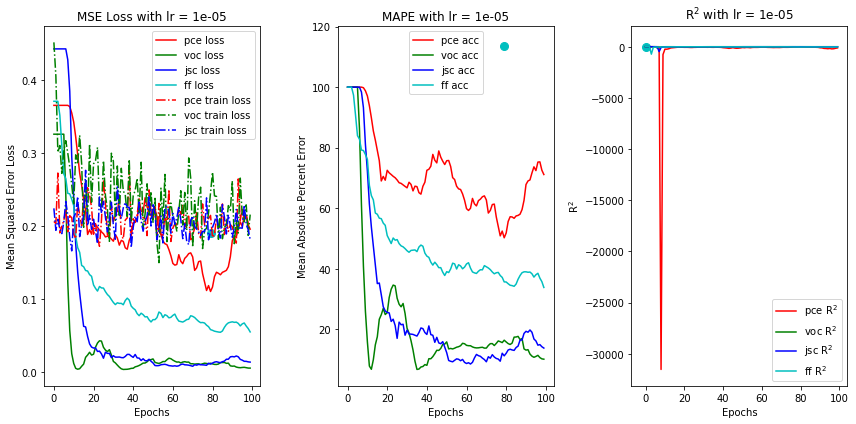

PCE epoch: 84
Voc epoch: 9
Jsc epoch: 91
FF epoch: 14


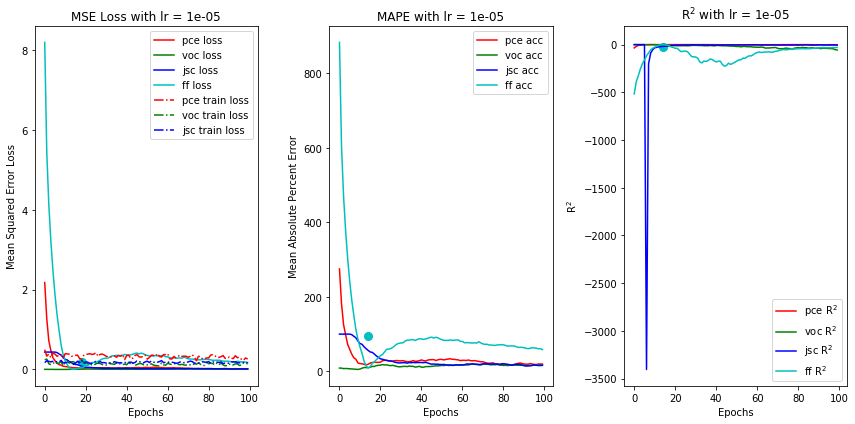

PCE epoch: 9
Voc epoch: 68
Jsc epoch: 0
FF epoch: 9


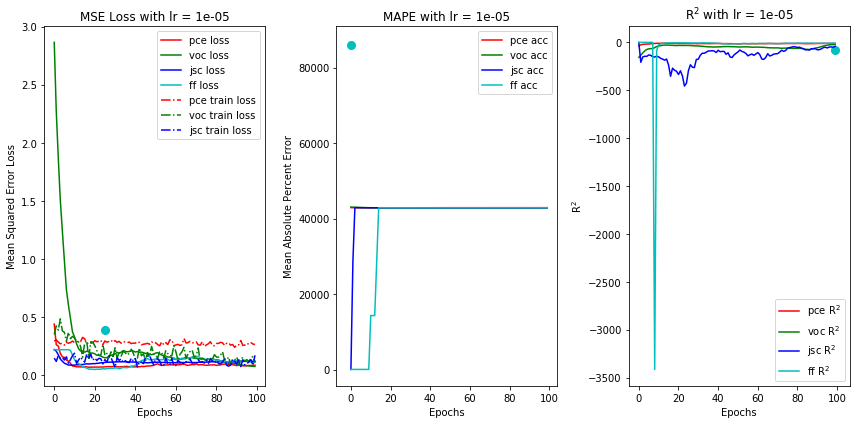

PCE epoch: 13
Voc epoch: 54
Jsc epoch: 2
FF epoch: 0


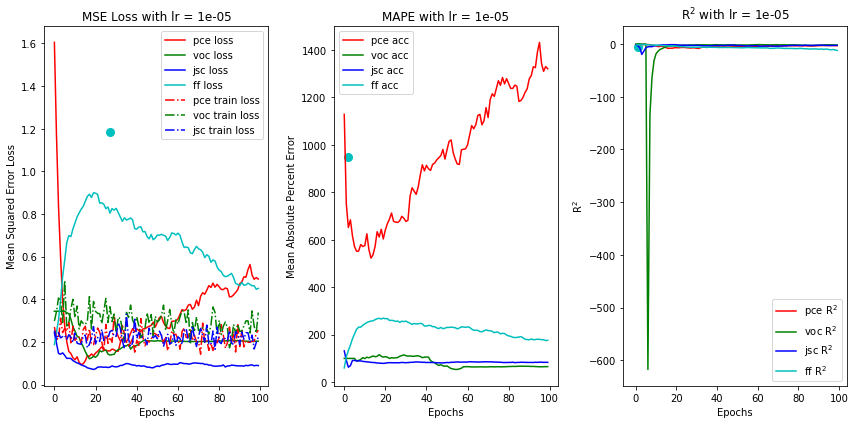

PCE epoch: 70
Voc epoch: 69
Jsc epoch: 74
FF epoch: 9


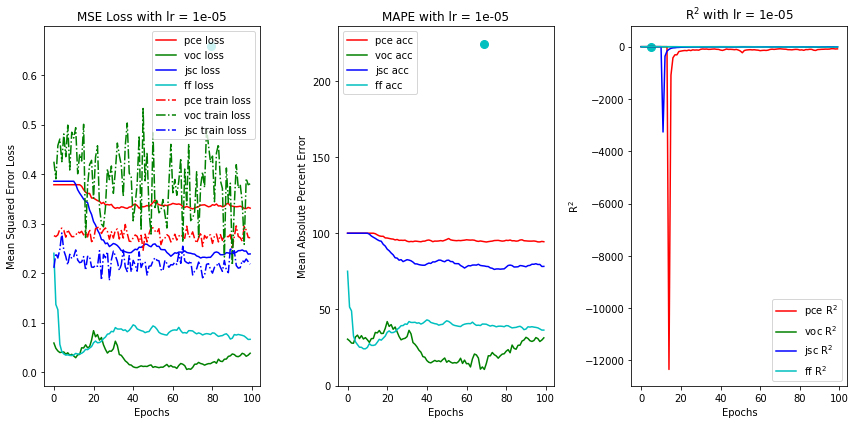

In [19]:
%autoreload

loss_summary = {}
acc_summary = {}
r2_summary = {}

pce_loss = []
pce_acc = []
pce_r2 = []
voc_loss = []
voc_acc = []
voc_r2 = []
jsc_loss = []
jsc_acc = []
jsc_r2 = []
ff_loss = []
ff_acc = []
ff_r2 = []


for key, fit_dict in data.items():
    plot_fit_results(fit_dict)
    losses, accs, r2s = report_metrics(fit_dict)
    
    pce_loss.append(losses[0])
    pce_acc.append(accs[0])
    pce_r2.append(r2s[0])
    
    voc_loss.append(losses[1])
    voc_acc.append(accs[1])
    voc_r2.append(r2s[1])
    
    jsc_loss.append(losses[2])
    jsc_acc.append(accs[2])
    jsc_r2.append(r2s[2])
    
    ff_loss.append(losses[3])
    ff_acc.append(accs[3])
    ff_r2.append(r2s[3])
    
    
loss_summary['PCE Worst'] = max(pce_loss)
loss_summary['PCE Avg'] = sum(pce_loss)/len(pce_loss)
loss_summary['PCE Best'] = min(pce_loss)

loss_summary['Voc Worst'] = max(voc_loss)
loss_summary['Voc Avg'] = sum(voc_loss)/len(voc_loss)
loss_summary['Voc Best'] = min(voc_loss)

loss_summary['Jsc Worst'] = max(jsc_loss)
loss_summary['Jsc Avg'] = sum(jsc_loss)/len(jsc_loss)
loss_summary['Jsc Best'] = min(jsc_loss)

loss_summary['FF Worst'] = max(ff_loss)
loss_summary['FF Avg'] = sum(ff_loss)/len(ff_loss)
loss_summary['FF Best'] = min(ff_loss)

acc_summary['PCE Worst'] = max(pce_acc)
acc_summary['PCE Avg'] = sum(pce_acc)/len(pce_acc)
acc_summary['PCE Best'] = min(pce_acc)

acc_summary['Voc Worst'] = max(voc_acc)
acc_summary['Voc Avg'] = sum(voc_acc)/len(voc_acc)
acc_summary['Voc Best'] = min(voc_acc)

acc_summary['Jsc Worst'] = max(jsc_acc)
acc_summary['Jsc Avg'] = sum(jsc_acc)/len(jsc_acc)
acc_summary['Jsc Best'] = min(jsc_acc)

acc_summary['FF Worst'] = max(ff_acc)
acc_summary['FF Avg'] = sum(ff_acc)/len(ff_acc)
acc_summary['FF Best'] = min(ff_acc)

r2_summary['PCE Worst'] = min(pce_r2)
r2_summary['PCE Avg'] = sum(pce_r2)/len(pce_r2)
r2_summary['PCE Best'] = max(pce_r2)

r2_summary['Voc Worst'] = min(voc_r2)
r2_summary['Voc Avg'] = sum(voc_r2)/len(voc_r2)
r2_summary['Voc Best'] = max(voc_r2)

r2_summary['Jsc Worst'] = min(jsc_r2)
r2_summary['Jsc Avg'] = sum(jsc_r2)/len(jsc_r2)
r2_summary['Jsc Best'] = max(jsc_r2)

r2_summary['FF Worst'] = min(ff_r2)
r2_summary['FF Avg'] = sum(ff_r2)/len(ff_r2)
r2_summary['FF Best'] = max(ff_r2)

In [20]:
loss_summary

{'PCE Worst': 0.32966163754463196,
 'PCE Avg': 0.12654352113604544,
 'PCE Best': 0.01787266507744789,
 'Voc Worst': 0.20425143837928772,
 'Voc Avg': 0.07343919470440596,
 'Voc Best': 0.001384108210913837,
 'Jsc Worst': 0.2304435819387436,
 'Jsc Avg': 0.12386672543361783,
 'Jsc Best': 0.007688672747462988,
 'FF Worst': 0.18753063678741455,
 'FF Avg': 0.09086440736427903,
 'FF Best': 0.0045028370805084705}

In [21]:
acc_summary

{'PCE Worst': 42874.78125,
 'PCE Avg': 8711.887285995483,
 'PCE Best': 17.336572647094727,
 'Voc Worst': 42861.59375,
 'Voc Avg': 8587.527086639404,
 'Voc Best': 5.137157440185547,
 'Jsc Worst': 76.24922180175781,
 'Jsc Avg': 43.8291732788086,
 'Jsc Best': 8.535833358764648,
 'FF Worst': 59.8881721496582,
 'FF Avg': 35.57445602416992,
 'FF Best': 8.84433364868164}

In [22]:
r2_summary

{'PCE Worst': -80.11171256171068,
 'PCE Avg': -24.057295732557378,
 'PCE Best': -0.16872254731804448,
 'Voc Worst': -58.35331806453876,
 'Voc Avg': -12.519104995369029,
 'Voc Best': -0.08021034213600675,
 'Jsc Worst': -6.827795045924916,
 'Jsc Avg': -3.077819236347646,
 'Jsc Best': 0.0,
 'FF Worst': -84.79611070416794,
 'FF Avg': -21.318901204125908,
 'FF Best': -0.02300407150131445}